In [1]:
#tensorflow_version 2.x
import tensorflow as tf
#from tf.keras.models import Sequential
#from tf.keras.layers import Dense


#Init GPU

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
# only if you want to see how commands are executed
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  print(gpus[0])
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPU


In [4]:
import os
import io
import torch
import stanza
import pandas as pd 
import re
import os.path
import stopwordsiso as stopwords


from os import path


en = stanza.download('en') 





tf.__version__

2022-03-10 20:48:21 INFO: Downloading default packages for language: en (English)...
2022-03-10 20:48:23 INFO: File exists: C:\Users\lukem\stanza_resources\en\default.zip.
2022-03-10 20:48:28 INFO: Finished downloading models and saved to C:\Users\lukem\stanza_resources.


'2.7.0'

#Download Data

Download the file
Save into a temp location

Unzip does not work in a windows enviroment


In [5]:

if not (path.exists("../data/spam/smsspamcollection.zip")):
    path_to_zip = tf.keras.utils.get_file("F:\\Users\\Luke\\Documents\\Git\\NPL\\Advanced-NLP-with-TensorFlow2\\data\\Spam\\smsspamcollection.zip",
                  origin="https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip",
                  extract=True)

    !unzip $path_to_zip -d data

lines = io.open('../data/spam/SMSSpamCollection').read().strip().split('\n')
lines[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

#Pre-Process Data

In [6]:
spam_dataset = []
count = 0
for line in lines:
  label, text = line.split('\t')
  if label.lower().strip() == 'spam':
    spam_dataset.append((1, text.strip()))
    count += 1
  else:
    spam_dataset.append(((0, text.strip())))

print(spam_dataset[0])
print("Spam: ", count)

(0, 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')
Spam:  747


#Data Normalization

In [ ]:

en = stanza.Pipeline(lang='en')
en_sw = stopwords.stopwords('en')
df = pd.DataFrame(spam_dataset, columns=['Spam', 'Message'])
#train=df.sample(frac=0.8,random_state=42) #random state is a seed value
#test=df.drop(train.index)

# Normalization functions

#def message_length(x):
#  # returns total number of characters
#  return len(x)

#def num_capitals(x):
#  _, count = re.subn(r'[A-Z]', '', x) # only works in english
#  return count

#def num_punctuation(x):
#  _, count = re.subn(r'\W', '', x)
#  return count

#def word_counts(x, pipeline=en):
#  doc = pipeline(x)
#  count = sum( [ len(sentence.tokens) for sentence in doc.sentences] )
#  return count

#def word_counts_clean(x, pipeline=en):
#  doc = pipeline(x)
#  count = 0
#  for sentence in doc.sentences:
#    for token in sentence.tokens:
#        if token.text.lower() not in en_sw:
#          count += 1
#  return count

#df['Capitals'] = df['Message'].apply(num_capitals)
#df['Punctuation'] = df['Message'].apply(num_punctuation)
#df['Length'] = df['Message'].apply(message_length)
#df['Words'] = df['Message'].apply(word_counts)
#df['CleanWords'] = df['Message'].apply(word_counts_clean)

def normaliseData(x, pipeline=en):
  try:
    print("\rprocessing line: "+x)
    doc = pipeline(x)
    length = len(x)
    _, capCount = re.subn(r'[A-Z]', '', x)
    _, punctuationCount = re.subn(r'\W', '', x)
  
    wordCount = sum( [ len(sentence.tokens) for sentence in doc.sentences] )
    totals = 0.
    count = 0.
    non_word = 0.
    for sentence in doc.sentences:
      totals += len(sentence.tokens)  # (1)
      for token in sentence.tokens:
          if token.text.lower() not in en_sw:
            if token.words[0].upos not in ['PUNCT', 'SYM']:
              count += 1.
            else:
              non_word += 1.
    non_word = non_word / totals
  except:
    capCount = -1
    punctuationCount = -1
    length = -1
    wordCount = -1
    count = -1
    non_word = -1
    print("Error processing line: "+x)
  finally:
    return pd.Series([capCount,punctuationCount,length,wordCount,count, non_word], 
    index=['Capitals','Punctuation','Length','Words','Words_NoPunct', 'Punct'])


if not (path.exists("../data/spam/model")):
  tmp_df = df['Message'].apply(normaliseData)
  df = pd.concat([df, tmp_df], axis=1)
  df.to_pickle("../data/spam/normaliseData.pkl")
else:
  df = pd.read_pickle("../data/spam/normaliseData.pkl")

train=df.sample(frac=0.8,random_state=42) #random state is a seed value
test=df.drop(train.index)



In [39]:
train.describe()

,Spam,Capitals,Punctuation,Length,Words,Words_NoPunct,Punct
count,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000
mean,0.132765,5.405248,18.737385,79.694550,18.533752,6.381924,0.142315
std,0.339359,11.332793,14.641426,59.476952,13.680827,5.617551,0.124327
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,1.000000,8.000000,35.000000,9.000000,2.000000,0.090909
50%,0.000000,2.000000,14.000000,61.000000,15.000000,4.000000,0.142857
75%,0.000000,4.000000,27.000000,121.000000,27.000000,9.000000,0.200000
max,1.000000,129.000000,253.000000,910.000000,209.000000,54.000000,0.666667


In [9]:
# Basic 1-layer neural network model for evaluation
def make_model(input_dims=3, num_units=12):
  model = tf.keras.Sequential()

  # Adds a densely-connected layer with 12 units to the model:
  model.add(tf.keras.layers.Dense(num_units, 
                                  input_dim=input_dims, 
                                  activation='relu'))

  # Add a sigmoid layer with a binary output unit:
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  return model

In [ ]:
#train.head(10)

In [12]:


#train['Words'] = train['Message'].apply(word_counts)
#test['Words'] = test['Message'].apply(word_counts)
x_train = train[['Capitals','Punctuation','Length','Words','Words_NoPunct', 'Punct']]
y_train = train[['Spam']]

x_test = test[['Capitals','Punctuation','Length','Words','Words_NoPunct', 'Punct']]
y_test = test[['Spam']]


if not (path.exists("../data/spam/model")):
    model = make_model(input_dims=6)
    model.fit(x_train, y_train, epochs=10, batch_size=10)
    model.evaluate(x_test, y_test)
    model.save('../data/spam/model')
else:
    model = tf.keras.models.load_model('../data/spam/model')

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)





Epoch 1/10
446/446 [==============================] - 5s 9ms/step - loss: 4.2601 - accuracy: 0.6892
Epoch 2/10
446/446 [==============================] - 4s 9ms/step - loss: 0.4369 - accuracy: 0.8784
Epoch 3/10
446/446 [==============================] - 4s 8ms/step - loss: 0.2504 - accuracy: 0.9282
Epoch 4/10
446/446 [==============================] - 4s 8ms/step - loss: 0.2025 - accuracy: 0.9401
Epoch 5/10
446/446 [==============================] - 4s 9ms/step - loss: 0.1820 - accuracy: 0.9446
Epoch 6/10
446/446 [==============================] - 4s 9ms/step - loss: 0.1801 - accuracy: 0.9424
Epoch 7/10
446/446 [==============================] - 4s 9ms/step - loss: 0.1740 - accuracy: 0.9433
Epoch 8/10
446/446 [==============================] - 4s 9ms/step - loss: 0.1737 - accuracy: 0.9419
Epoch 9/10
446/446 [==============================] - 4s 8ms/step - loss: 0.1670 - accuracy: 0.9426
Epoch 10/10
35/35 [==============================] - 0s 6ms/step - loss: 0.1918 - accuracy: 0.9417
I

#Closer to on

In [59]:
def checkIfMsgIsSpam(msg):
    sample = pd.DataFrame([msg], columns=['Message'])
    tmp_sample = sample['Message'].apply(normaliseData)
    #tmp_sample.head()
    sample = pd.concat([sample, tmp_sample], axis=1)
    sample_pred = model.predict(sample[['Capitals','Punctuation','Length','Words','Words_NoPunct', 'Punct']])
    return sample_pred


sample_pred = checkIfMsgIsSpam("Sunshine Quiz Wkly Q! Win a top Sony DVD player if u know which country the Algarve is in? Txt ansr to 82277. £1.50 SP:Tyrone")

sample_pred[0][0]

processing line: Sunshine Quiz Wkly Q! Win a top Sony DVD player if u know which country the Algarve is in? Txt ansr to 82277. £1.50 SP:Tyrone


0.7698292

In [54]:
import numpy as np
t = np.squeeze(y_test_pred).round() #.tolist()

t


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
y_test['Spam'].values.tolist()

Confusion matrix, without normalization


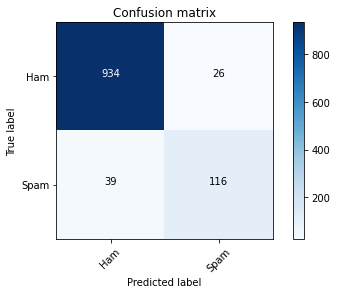

In [56]:
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



cm = metrics.confusion_matrix(y_test['Spam'].values.tolist(), t)
plot_confusion_matrix(cm, classes=['Ham', 'Spam'])

In [ ]:
y_train

In [22]:
y_test_pred

array([[0.00252632],
       [0.01168844],
       [0.03557014],
       ...,
       [0.17161897],
       [0.01739425],
       [0.01193297]], dtype=float32)

#Tokenization and Stop Word Removal

In [ ]:
# StanfordNLP has become https://github.com/stanfordnlp/stanza/
#!pip install stanza  

In [ ]:
#sentence = 'Go until jurong point, crazy.. Available only in bugis n great world'
#sentence.split()

In [ ]:
#tokenized = en(sentence)
#len(tokenized.sentences)


#for snt in tokenized.sentences:
#  for word in snt.tokens:
#    print(word.text)
#  print("<End of Sentence>")

In [ ]:

#train['Words'] = train['Message'].apply(word_counts)
#test['Words'] = test['Message'].apply(word_counts)
#x_train = train[['Length', 'Punctuation', 'Capitals', 'Words']]
#y_train = train[['Spam']]

#x_test = test[['Length', 'Punctuation', 'Capitals' , 'Words']]
#y_test = test[['Spam']]


#if not (path.exists("../data/spam/model2")):
#    model = make_model(input_dims=4)
#    model.fit(x_train, y_train, epochs=10, batch_size=10)
#    model.evaluate(x_test, y_test)
#    model.save('../data/spam/model2')
#else:
#    model = tf.keras.models.load_model('../data/spam/model2')
